In [2]:
import os
import time
import torch
import torchvision
import numpy as np
from tqdm import tqdm
from torch import optim
from scipy.ndimage import zoom
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

from utils import * 
from model import SAM_CFFNet

In [4]:
def parse_args():
    import argparse
    parser = argparse.ArgumentParser(description="pytorch SAM_CFFNet training")
    parser.add_argument("--local_rank"     , default = 0, type=int,  help="")
    parser.add_argument("--dataset"        , choices = ["BJL", "L4S", "GVLM"], default="GVLM")
    parser.add_argument("--sam_pretrained_weights", default = '/pretrained/sam_vit_l_0b3195.pth', type=str, help="path to SAM model pretrained weights file")
    parser.add_argument("--encoder_mode"   , default= "l")
    parser.add_argument('--modelname'      , default = 'SAM_CFFNet', type=str, metavar='data', help='model name')
    parser.add_argument("--batch_size"     , default = 2, type=int,  help="")
    parser.add_argument("--num_classes"    , default = 1 + 1, type=int, help="加上背景")
    parser.add_argument('--epochs'         , default = 30, type=int, metavar='N', help='total epochs')
    parser.add_argument('--lr'             , default = 0.0002, type=float, help='initial learning rate')
    parser.add_argument('--lr_min'         , default = 1e-07, type=float)
    parser.add_argument('--inp_size'       , default = 1024, type=float)
    parser.add_argument('--resume'         , default = '/home/mw/work/sam_cffnet', type=str, metavar='PATH')
    parser.add_argument("--device"         , default = 'cpu', type=str,  help="")
    parser.add_argument('--momentum', default=0.9, type=float, metavar='M',help='momentum')

    # args = parser.parse_args()

    args = parser.parse_known_args()[0]

    return args

In [4]:
seed_everything(100)
args = parse_args()

args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print("Training On Device: ", args.device)

if not os.path.exists(args.resume):   
    os.makedirs(args.resume)
print(f" 模型训练数据保存地址为：{args.resume}\n 训练batch size为：{args.batch_size}\n 训练轮次为：{args.epochs}")



optimizer_list = {'name': 'adamw', 'args': {'lr': args.lr}}
epoch_max = args.epochs


sam_cffnet = SAM_CFFNet(args)

optimizer = make_optimizer(sam_cffnet.parameters(), optimizer_list)

lr_scheduler = CosineAnnealingLR(optimizer, epoch_max , args.lr_min)

model = sam_cffnet.cuda()

model_total_params = sum(p.numel() for p in model.parameters())
model_grad_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('model_grad_params :' + str(model_grad_params), '\nmodel_total_params:' + str(model_total_params))

train_loader, val_loader = make_data_loaders(args)

msl   = Model_save_log(save_path = args.resume, max_epoch = args.epochs)

evaluator = Evaluator(2)
start_time = time.time()
for epoch in range(args.epochs):

    train_result = training(     train_loader, model, optimizer, epoch, evaluator, args)
    test_reselt  = validationing(val_loader,   model,            epoch, evaluator, args)
    lr_scheduler.step() 

    # 记录训练信息
    msl.get_val_result(train_result, test_reselt, model.state_dict(), optimizer.state_dict(), epoch)



权重保存策略：保存在 测试精度、IOU_1，损失方面提高的模型，保存地址为：/home/mw/work/sam_cffnet


In [8]:
# 训练结束
duration_in_seconds = time_trans(start_time, time.time())
# 打印时长
print(f"共耗时长: {duration_in_seconds}")

共耗时长: 309 m 31 s


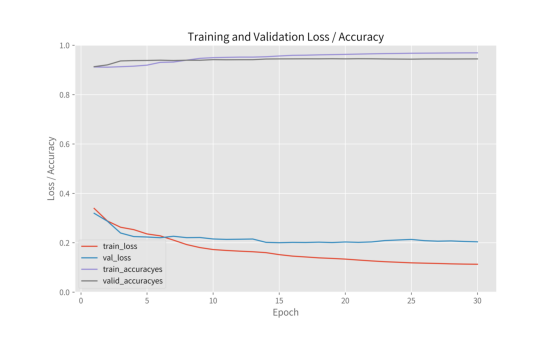

In [4]:
# 显示训练曲线
msl.plot_fig()